In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import nltk
import re
from nltk.corpus import stopwords
import tensorflow as tf

In [2]:
# Load the dataset
df = pd.read_csv('labeled_data.csv')
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [3]:
# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [4]:
df.drop(columns=['Unnamed: 0', 'count', 'hate_speech', 'offensive_language', 'neither'], inplace=True)
df["class"] = df['class'].map({0: 'Hate Speech', 1: 'Offensive Speech', 2: 'No Hate and Offensive Speech'})
df["binary_class"] = df["class"].map({'Hate Speech': 1, 'Offensive Speech': 1, 'No Hate and Offensive Speech': 0})
df.drop(columns=['class'], inplace=True)

In [5]:
df.head()

,tweet,binary_class
0,!!! RT @mayasolovely: As a woman you shouldn't...,0
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,1
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,1
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,1
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,1


In [6]:
# Clean the text
nltk.download('stopwords')
stopword = set(stopwords.words('english'))
stemmer = nltk.SnowballStemmer("english")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [7]:
def clean(text):
    text = str(text).lower()
    text = re.sub('[,?]', '', text)
    text = re.sub('https?://\S+|www.\S+', '', text)
    text = re.sub('<,?>+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w\d\w', '', text)
    text = [word for word in text.split(' ') if word not in stopword]
    text = " ".join(text)
    text = [stemmer.stem(word) for word in text.split(' ')]
    text = " ".join(text)
    return text

In [8]:
df["tweet"] = df["tweet"].apply(clean)

In [9]:
# Tokenize and pad sequences
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df["tweet"])
x = tokenizer.texts_to_sequences(df["tweet"])
x = pad_sequences(x, maxlen=100)

In [10]:
print("Maximum sequence length:", x.shape[1])

Maximum sequence length: 100


In [11]:
y = np.array(df["binary_class"])

In [12]:
# Split the dataset
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

**LSTM** **Model**

In [13]:
# Define the LSTM Model
model1 = Sequential()
model1.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=x.shape[1]))
model1.add(LSTM(100))
model1.add(Dense(1, activation='sigmoid'))

In [14]:
model1.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

In [136]:
# Display the model summary
model1.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 100, 100)          3150500   
                                                                 
 lstm_3 (LSTM)               (None, 100)               80400     
                                                                 
 dense_17 (Dense)            (None, 1)                 101       
                                                                 
Total params: 3231001 (12.33 MB)
Trainable params: 3231001 (12.33 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [15]:
# Define early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [16]:
# Train the model
history = model1.fit(x_train, y_train, epochs=5, validation_split=0.2, callbacks=[early_stopping], batch_size=64)


Epoch 1/5
208/208 [==============================] - 64s 268ms/step - loss: 0.2616 - accuracy: 0.8908 - val_loss: 0.1233 - val_accuracy: 0.9512
Epoch 2/5
208/208 [==============================] - 48s 230ms/step - loss: 0.0941 - accuracy: 0.9650 - val_loss: 0.1261 - val_accuracy: 0.9512
Epoch 3/5
208/208 [==============================] - 53s 255ms/step - loss: 0.0611 - accuracy: 0.9791 - val_loss: 0.1329 - val_accuracy: 0.9494
Epoch 4/5
208/208 [==============================] - 49s 237ms/step - loss: 0.0428 - accuracy: 0.9868 - val_loss: 0.1744 - val_accuracy: 0.9416


In [17]:
# Evaluate the model
y_pred_prob = model1.predict(x_test)
y_pred = (y_pred_prob > 0.5).astype(int)

accuracy_model1 = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy_model1)

256/256 [==============================] - 8s 30ms/step
Accuracy: 0.9404572686147451


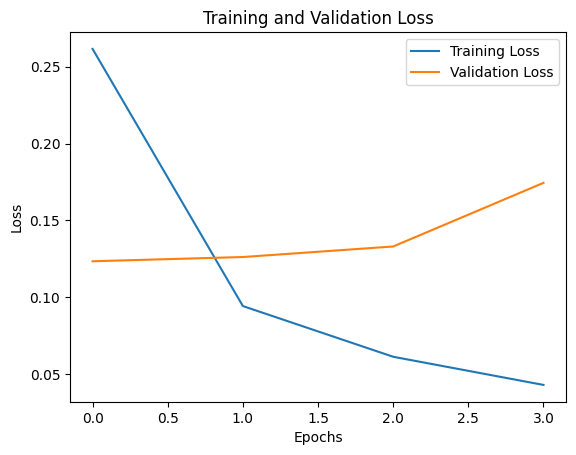

In [18]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


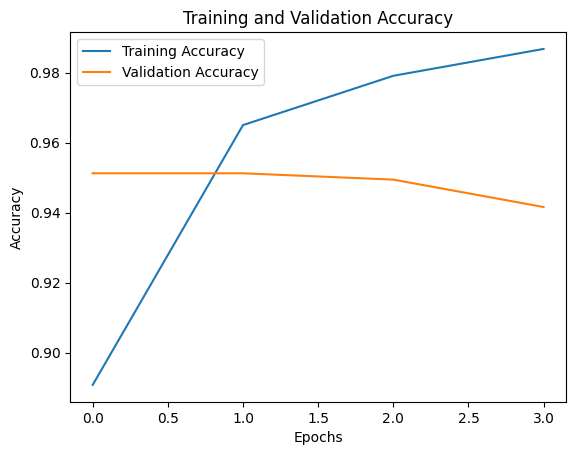

In [19]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


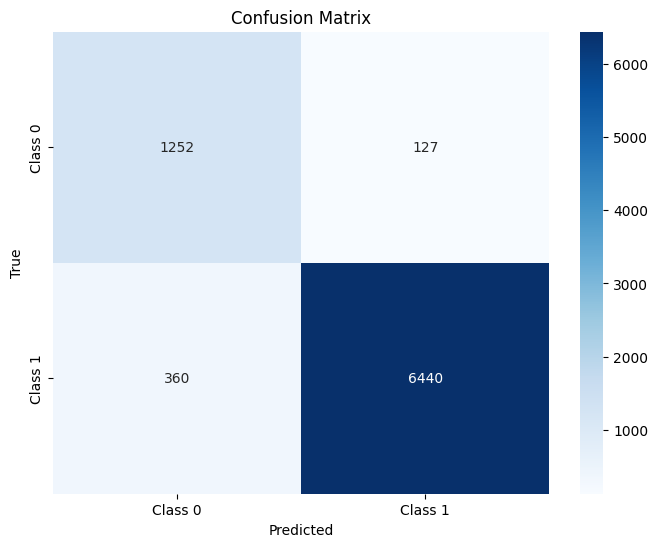

In [20]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


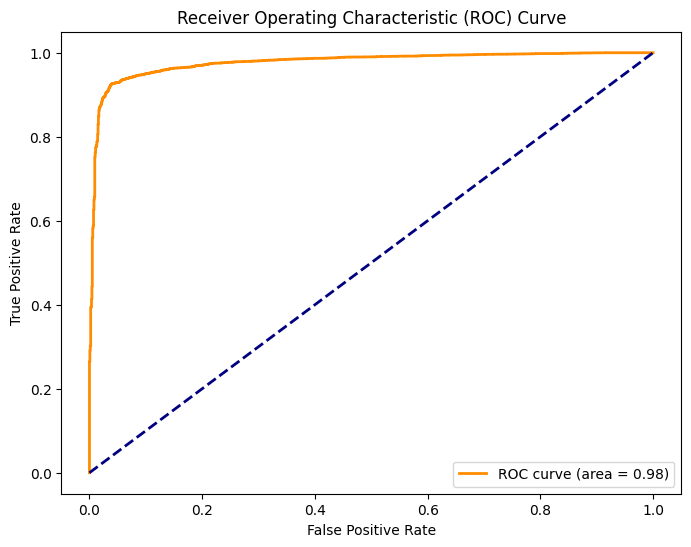

In [21]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


In [22]:
# Test the model with a new input
new_input = "dumb"
new_input = clean(new_input)
new_input = tokenizer.texts_to_sequences([new_input])
new_input = pad_sequences(new_input, maxlen=x.shape[1])
prediction_prob = model1.predict(new_input)
predicted_class = "Hate Speech" if prediction_prob > 0.5 else "No Hate and Offensive Speech"
print("Predicted Class:", predicted_class)

1/1 [==============================] - 0s 41ms/step
Predicted Class: Hate Speech


In [23]:
new_input = "thats so nice of you"
new_input = clean(new_input)
new_input = tokenizer.texts_to_sequences([new_input])
new_input = pad_sequences(new_input, maxlen=x.shape[1])
prediction_prob = model1.predict(new_input)
predicted_class = "Hate Speech" if prediction_prob > 0.5 else "No Hate and Offensive Speech"
print("Predicted Class:", predicted_class)

1/1 [==============================] - 0s 34ms/step
Predicted Class: No Hate and Offensive Speech


**RNN Model**

In [40]:
# Define the RNN Model
embedding_dim = 128
model2 = Sequential()
model2.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=embedding_dim, input_length=x.shape[1]))
model2.add(LSTM(128))
model2.add(Dense(64, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))

In [41]:
# Compile the model
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [42]:
# Display the model summary
model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 128)          4032640   
                                                                 
 lstm_2 (LSTM)               (None, 128)               131584    
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4172545 (15.92 MB)
Trainable params: 4172545 (15.92 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [43]:
# Train the model
history = model2.fit(x_train, y_train, epochs=10, validation_split=0.2, callbacks=[EarlyStopping(patience=3, restore_best_weights=True)])

Epoch 1/10
416/416 [==============================] - 109s 257ms/step - loss: 0.1986 - accuracy: 0.9174 - val_loss: 0.1152 - val_accuracy: 0.9557
Epoch 2/10
416/416 [==============================] - 108s 259ms/step - loss: 0.0842 - accuracy: 0.9687 - val_loss: 0.1366 - val_accuracy: 0.9437
Epoch 3/10
416/416 [==============================] - 104s 249ms/step - loss: 0.0558 - accuracy: 0.9801 - val_loss: 0.1354 - val_accuracy: 0.9470
Epoch 4/10
416/416 [==============================] - 101s 243ms/step - loss: 0.0382 - accuracy: 0.9862 - val_loss: 0.1929 - val_accuracy: 0.9416


In [44]:
# Evaluate the model
y_pred_prob = model2.predict(x_test)
y_pred = (y_pred_prob > 0.5).astype(int)

accuracy_model2 = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy_model2)

256/256 [==============================] - 15s 56ms/step
Accuracy: 0.9466927497249052


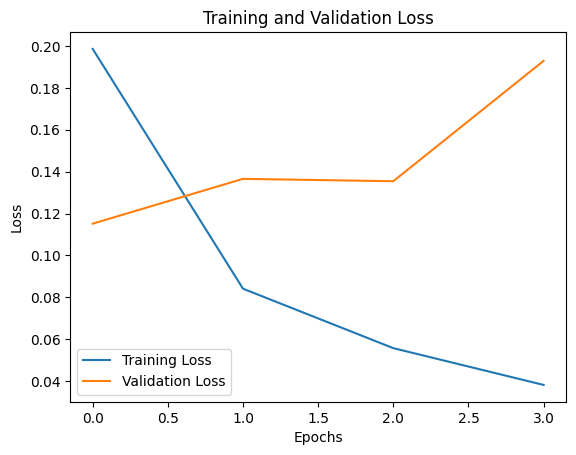

In [45]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

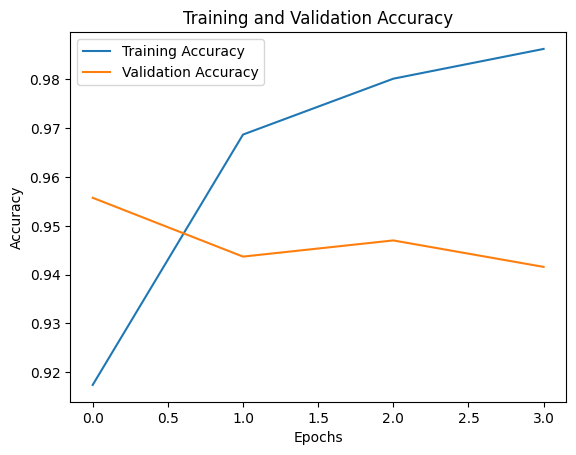

In [46]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

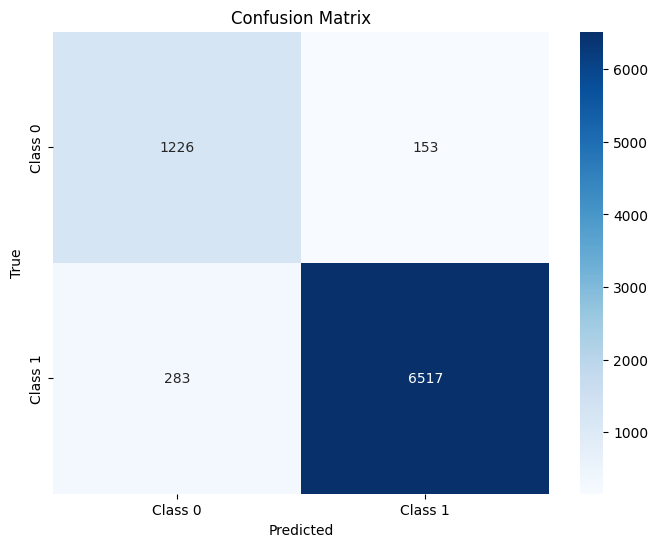

In [47]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

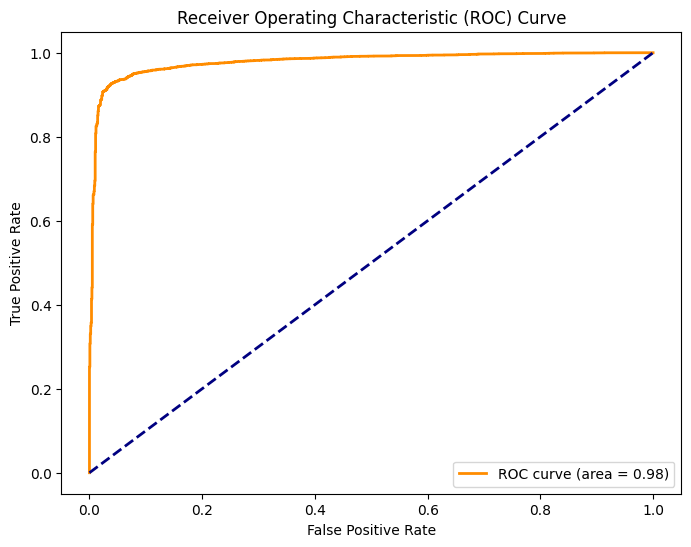

In [48]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


In [52]:
# Test the model with a new input
new_input = "you look awful"
new_input = clean(new_input)
new_input = tokenizer.texts_to_sequences([new_input])
new_input = pad_sequences(new_input, maxlen=x.shape[1])
prediction_prob = model2.predict(new_input)
predicted_class = "Hate Speech" if prediction_prob > 0.5 else "No Hate and Offensive Speech"
print("Predicted Class:", predicted_class)

1/1 [==============================] - 0s 80ms/step
Predicted Class: Hate Speech


In [53]:
new_input = "so pretty"
new_input = clean(new_input)
new_input = tokenizer.texts_to_sequences([new_input])
new_input = pad_sequences(new_input, maxlen=x.shape[1])
prediction_prob = model2.predict(new_input)
predicted_class = "Hate Speech" if prediction_prob > 0.5 else "No Hate and Offensive Speech"
print("Predicted Class:", predicted_class)

1/1 [==============================] - 0s 67ms/step
Predicted Class: No Hate and Offensive Speech


**CNN Model**

In [54]:
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout

# Define the CNN Model
embedding_dim = 128
model3 = Sequential()
model3.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=embedding_dim, input_length=x.shape[1]))
model3.add(Conv1D(128, 5, activation='relu'))
model3.add(MaxPooling1D(2))
model3.add(Conv1D(64, 5, activation='relu'))
model3.add(MaxPooling1D(2))
model3.add(Flatten())
model3.add(Dense(128, activation='relu'))
model3.add(Dropout(0.5))
model3.add(Dense(64, activation='relu'))
model3.add(Dropout(0.5))
model3.add(Dense(1, activation='sigmoid'))

In [55]:
# Compile the model
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [56]:
# Display the model summary
model3.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 100, 128)          4032640   
                                                                 
 conv1d_2 (Conv1D)           (None, 96, 128)           82048     
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 48, 128)           0         
 g1D)                                                            
                                                                 
 conv1d_3 (Conv1D)           (None, 44, 64)            41024     
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 22, 64)            0         
 g1D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 1408)             

In [57]:
# Train the model
history = model3.fit(x_train, y_train, epochs=10, validation_split=0.2,callbacks=[EarlyStopping(patience=3, restore_best_weights=True)])

Epoch 1/10
416/416 [==============================] - 54s 125ms/step - loss: 0.2350 - accuracy: 0.8973 - val_loss: 0.1334 - val_accuracy: 0.9470
Epoch 2/10
416/416 [==============================] - 53s 127ms/step - loss: 0.1138 - accuracy: 0.9569 - val_loss: 0.1274 - val_accuracy: 0.9479
Epoch 3/10
416/416 [==============================] - 54s 129ms/step - loss: 0.0609 - accuracy: 0.9793 - val_loss: 0.1537 - val_accuracy: 0.9425
Epoch 4/10
416/416 [==============================] - 51s 124ms/step - loss: 0.0327 - accuracy: 0.9881 - val_loss: 0.2215 - val_accuracy: 0.9452
Epoch 5/10
416/416 [==============================] - 52s 124ms/step - loss: 0.0172 - accuracy: 0.9937 - val_loss: 0.3364 - val_accuracy: 0.9398


In [58]:
# Evaluate the model
y_pred_prob = model3.predict(x_test)
y_pred = (y_pred_prob > 0.5).astype(int)

accuracy_model3 = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy_model3)

256/256 [==============================] - 4s 15ms/step
Accuracy: 0.9427802909891184


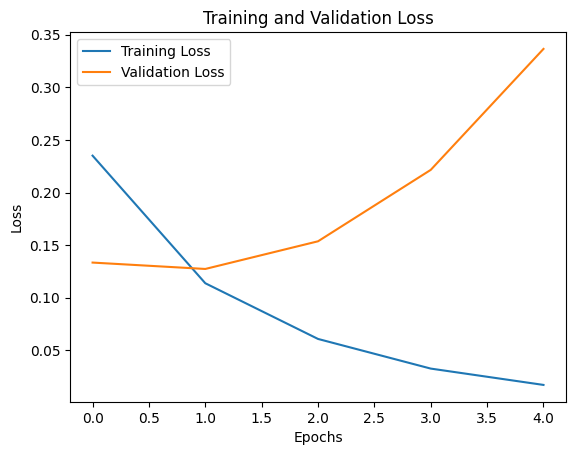

In [59]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

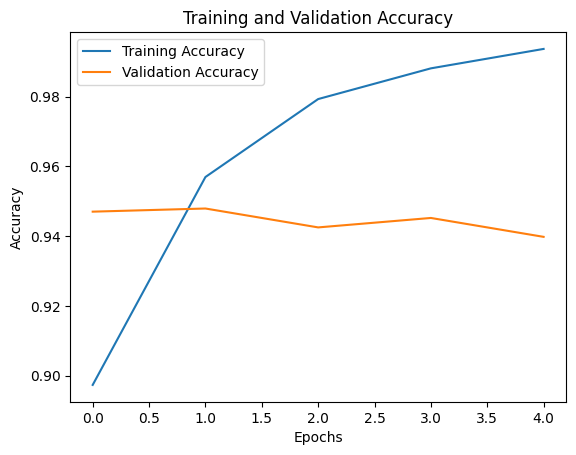

In [60]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

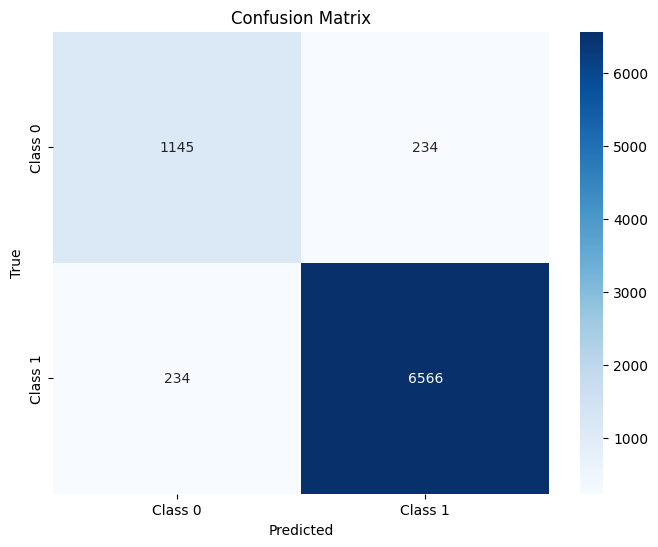

In [61]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

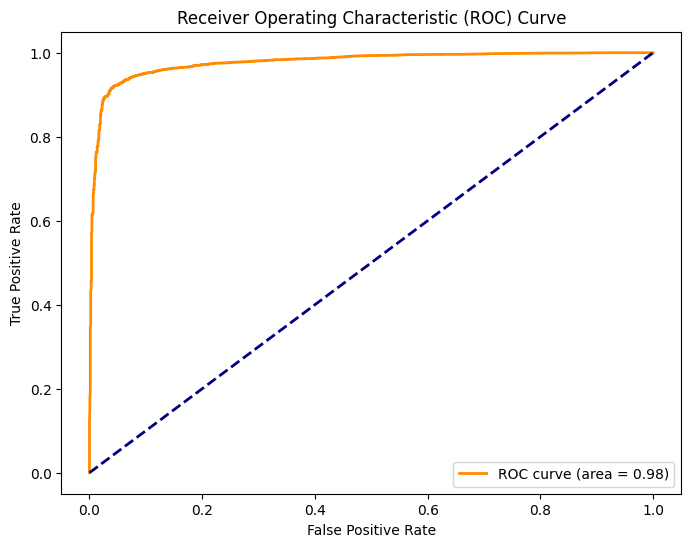

In [62]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


In [69]:
# Test the model with a new input
new_input = "i would rather kill you"
new_input = clean(new_input)
new_input = tokenizer.texts_to_sequences([new_input])
new_input = pad_sequences(new_input, maxlen=x.shape[1])
prediction_prob = model3.predict(new_input)
predicted_class = "Hate Speech" if prediction_prob > 0.5 else "No Hate and Offensive Speech"
print("Predicted Class:", predicted_class)

1/1 [==============================] - 0s 25ms/step
Predicted Class: Hate Speech


In [70]:
new_input = "good to go"
new_input = clean(new_input)
new_input = tokenizer.texts_to_sequences([new_input])
new_input = pad_sequences(new_input, maxlen=x.shape[1])
prediction_prob = model3.predict(new_input)
predicted_class = "Hate Speech" if prediction_prob > 0.5 else "No Hate and Offensive Speech"
print("Predicted Class:", predicted_class)

1/1 [==============================] - 0s 30ms/step
Predicted Class: No Hate and Offensive Speech


**ANN** **Model**

In [85]:
# Define the ANN Model
embedding_dim = 128
model4 = Sequential()
model4.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=embedding_dim, input_length=x.shape[1]))
model4.add(Flatten())  # Flatten layer to convert 2D input to 1D
model4.add(Dense(128, activation='relu'))
model4.add(Dropout(0.5))  # Adding dropout for regularization
model4.add(Dense(64, activation='relu'))
model4.add(Dropout(0.5))
model4.add(Dense(1, activation='sigmoid'))

In [86]:
# Compile the model
model4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [87]:
# Display the model summary
model4.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 100, 128)          4032640   
                                                                 
 flatten_3 (Flatten)         (None, 12800)             0         
                                                                 
 dense_14 (Dense)            (None, 128)               1638528   
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_15 (Dense)            (None, 64)                8256      
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_16 (Dense)            (None, 1)                

In [88]:
# Train the model
history = model4.fit(x_train, y_train, epochs=10, validation_split=0.2, callbacks=[EarlyStopping(patience=3, restore_best_weights=True)])

Epoch 1/10
416/416 [==============================] - 44s 103ms/step - loss: 0.2555 - accuracy: 0.8939 - val_loss: 0.1207 - val_accuracy: 0.9539
Epoch 2/10
416/416 [==============================] - 42s 100ms/step - loss: 0.0962 - accuracy: 0.9663 - val_loss: 0.1312 - val_accuracy: 0.9488
Epoch 3/10
416/416 [==============================] - 42s 101ms/step - loss: 0.0441 - accuracy: 0.9866 - val_loss: 0.1644 - val_accuracy: 0.9476
Epoch 4/10
416/416 [==============================] - 41s 98ms/step - loss: 0.0201 - accuracy: 0.9949 - val_loss: 0.2516 - val_accuracy: 0.9401


In [89]:
# Evaluate the model
y_pred_prob = model4.predict(x_test)
y_pred = (y_pred_prob > 0.5).astype(int)

accuracy_model4 = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy_model4)

256/256 [==============================] - 1s 5ms/step
Accuracy: 0.9429025553246118


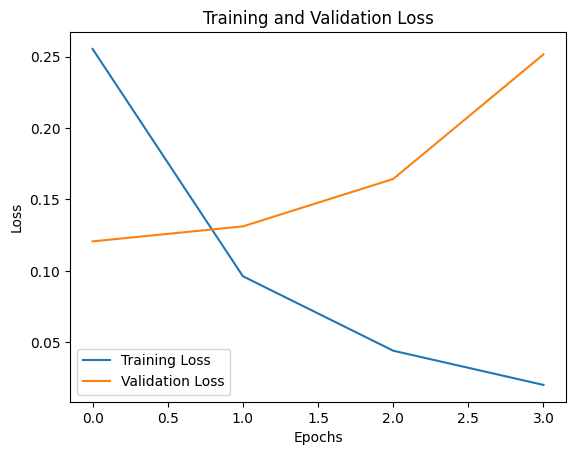

In [90]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

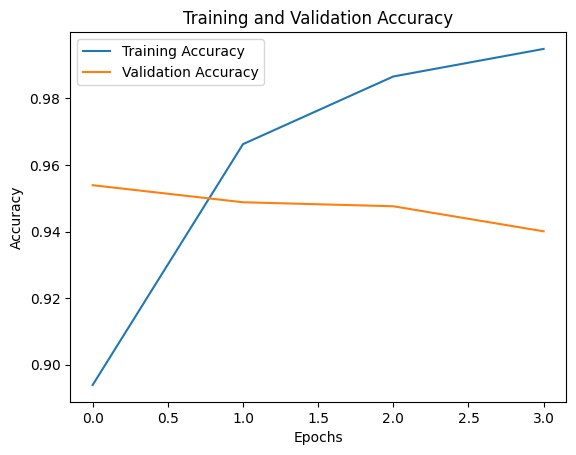

In [91]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

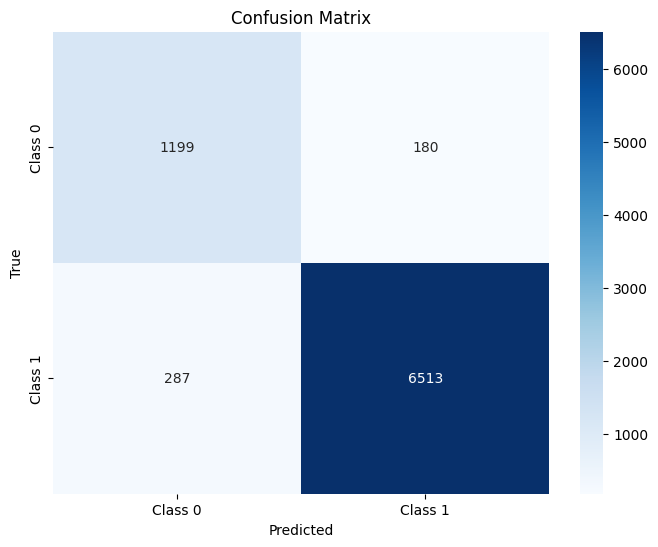

In [92]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

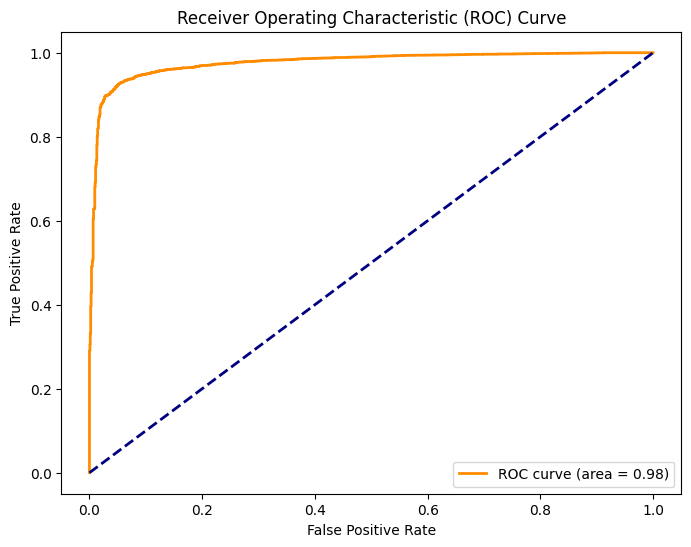

In [93]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


In [94]:
# Test the model with a new input
new_input = "you are stupid"
new_input = clean(new_input)
new_input = tokenizer.texts_to_sequences([new_input])
new_input = pad_sequences(new_input, maxlen=x.shape[1])
prediction_prob = model4.predict(new_input)
predicted_class = "Hate Speech" if prediction_prob > 0.5 else "No Hate and Offensive Speech"
print("Predicted Class:", predicted_class)

1/1 [==============================] - 0s 38ms/step
Predicted Class: Hate Speech


In [95]:
new_input = "you are pretty"
new_input = clean(new_input)
new_input = tokenizer.texts_to_sequences([new_input])
new_input = pad_sequences(new_input, maxlen=x.shape[1])
prediction_prob = model4.predict(new_input)
predicted_class = "Hate Speech" if prediction_prob > 0.5 else "No Hate and Offensive Speech"
print("Predicted Class:", predicted_class)

1/1 [==============================] - 0s 34ms/step
Predicted Class: No Hate and Offensive Speech


**Visualizations**

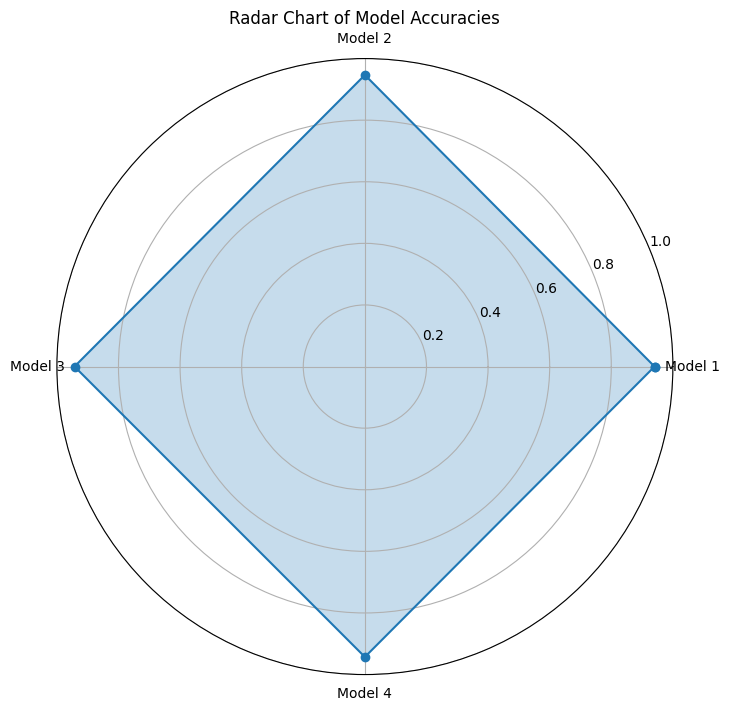

In [96]:
import numpy as np
import matplotlib.pyplot as plt

labels = ['Model 1', 'Model 2', 'Model 3', 'Model 4']
accuracies = [accuracy_model1, accuracy_model2, accuracy_model3, accuracy_model4]

angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
accuracies += accuracies[:1]
angles += angles[:1]

plt.figure(figsize=(8, 8))
plt.polar(angles, accuracies, marker='o')
plt.fill(angles, accuracies, alpha=0.25)
plt.title('Radar Chart of Model Accuracies')
plt.xticks(angles[:-1], labels)
plt.ylim(0, 1)
plt.show()


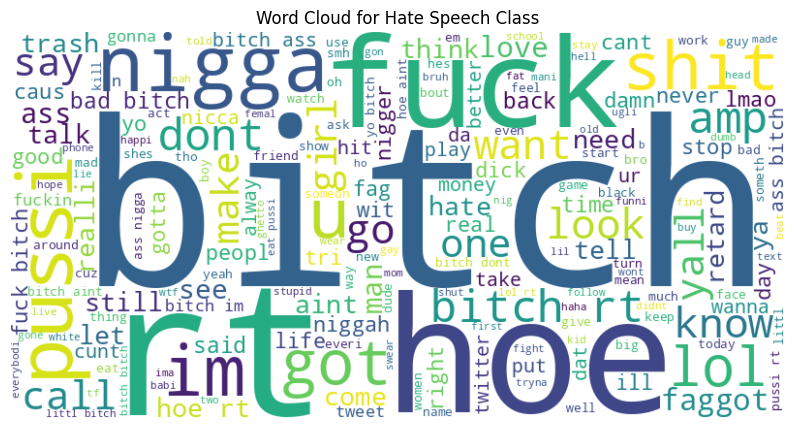

In [135]:
from wordcloud import WordCloud

# Extract Hate Speech tweets
hate_speech_tweets = df[df['binary_class'] == 1]['tweet'].values

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(hate_speech_tweets))

# Plot word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Hate Speech Class')
plt.show()


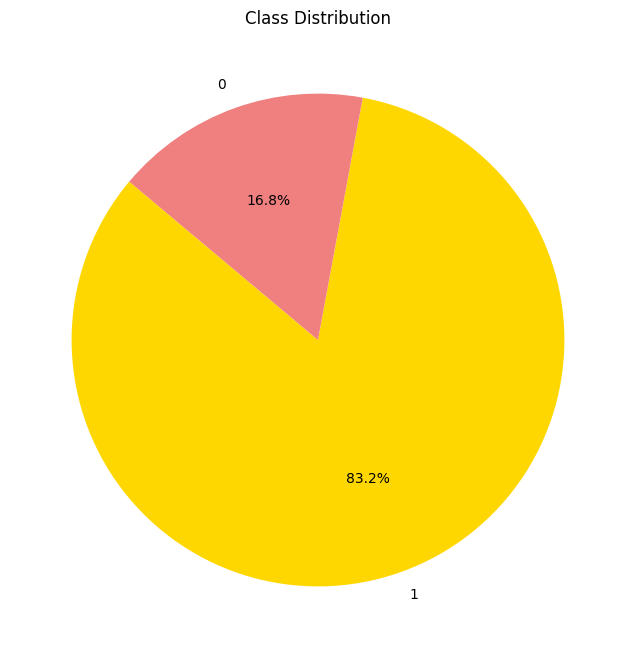

In [100]:
# About the classes of our dataset
class_distribution = df['binary_class'].value_counts()
colors = ['gold', 'lightcoral', 'lightskyblue']

plt.figure(figsize=(8, 8))
plt.pie(class_distribution, labels=class_distribution.index, autopct='%1.1f%%', colors=colors, startangle=140)
plt.title('Class Distribution')
plt.show()

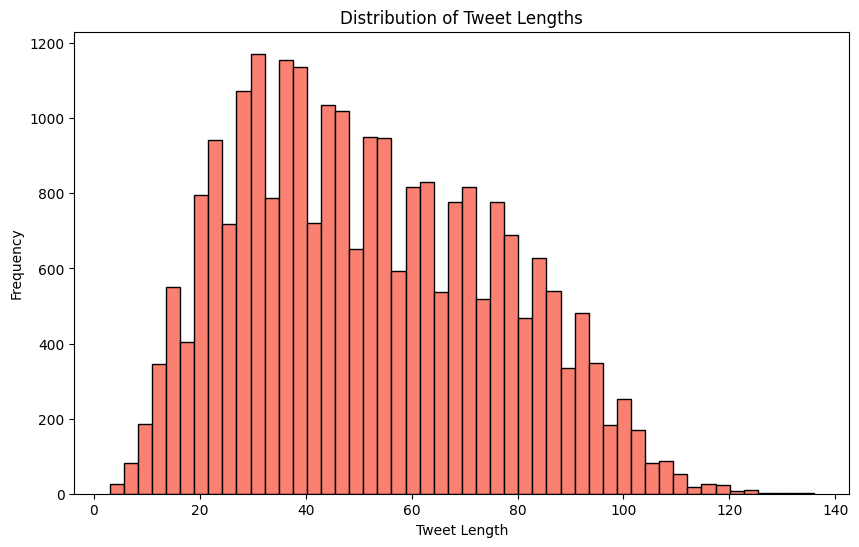

In [101]:
# Histogram showing the distribution of tweet lengths.
tweet_lengths = df['tweet'].apply(len)

plt.figure(figsize=(10, 6))
plt.hist(tweet_lengths, bins=50, color='salmon', edgecolor='black')
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.title('Distribution of Tweet Lengths')
plt.show()

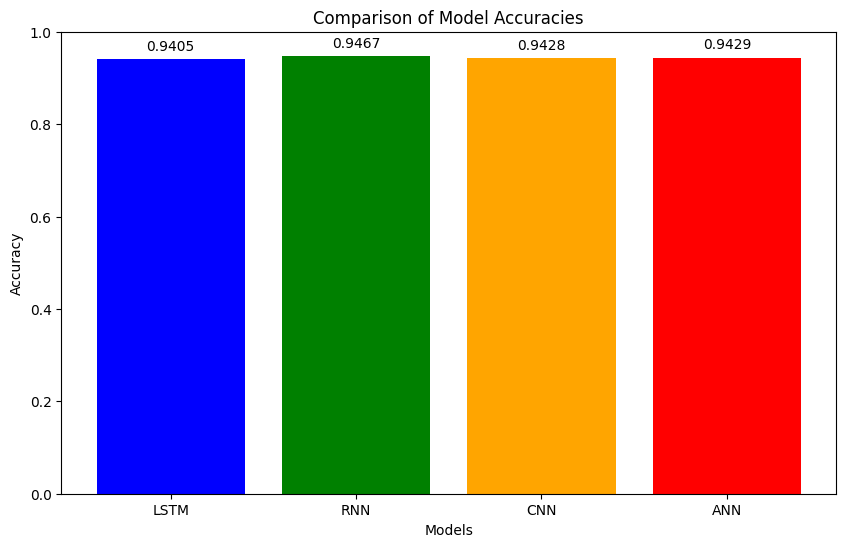

In [106]:
import matplotlib.pyplot as plt
import numpy as np

accuracies = [accuracy_model1, accuracy_model2, accuracy_model3, accuracy_model4]
models = ['LSTM', 'RNN', 'CNN', 'ANN']

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(models, accuracies, color=['blue', 'green', 'orange', 'red'])
plt.ylim(0, 1)  # Set y-axis limit from 0 to 1 (since accuracy is a percentage)

# Adding labels and title
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Comparison of Model Accuracies')

# Displaying the values on top of the bars
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.02, f'{v:.4f}', color='black', ha='center')

# Show the plot
plt.show()
